In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo import spa

from nengo_learn_assoc_mem.utils import BasicVecFeed

In [2]:
t_present = 0.3
t_pause = 0.1
dimensions = 32
n_neurons = 25
dt = 0.001
seed = 8

In [3]:
t_pres = int(t_present / dt)
t_paus = int(t_pause / dt)
slc_tm = (t_paus+t_pres)

In [4]:
rng = np.random.RandomState(seed=seed)
vocab = spa.Vocabulary(dimensions, rng=rng)

fan1 = ["CAT+DOG", "DUCK+FISH", "HORSE+COW"]
fan1_vecs = []
fan1_labels = ["F11", "F12", "F13"]

fan2 = ["PIG+RAT", "PIG+GOAT", "SHEEP+EMU", "SHEEP+GOOSE"]
fan2_vecs = []
fan2_labels = ["F21", "F22", "F23", "F24"]

for vec in fan1:
    fan1_vecs.append(vocab.parse(vec).v)

for vec in fan2:
    fan2_vecs.append(vocab.parse(vec).v)

/home/saubin/git/nengo/nengo/spa/vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=10)
  len(self.pointers)))


In [5]:
all_vecs = np.concatenate((fan1_vecs, fan2_vecs))
simi = np.dot(all_vecs, all_vecs.T)
np.fill_diagonal(simi, 0.)
intercept = np.ceil(np.max(simi)*100)/100
print(intercept)

0.8


In [6]:
print(all_vecs.shape)
print(np.abs(np.sum(all_vecs, axis=1)))

(7, 32)
[ 0.18000153  2.08292637  0.0251363   1.38284849  0.24465367  2.14219296
  1.18629499]


In [7]:
all_labels = fan1 + fan2

# Basic associative memory

In [8]:
data_feed = BasicVecFeed(all_vecs, all_vecs, t_present, dimensions, len(all_vecs), t_pause)

with nengo.Network() as model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)

    mem = nengo.networks.AssociativeMemory(all_vecs, n_neurons=n_neurons, threshold=0.1)
    
    nengo.Connection(stim, mem.input, synapse=None)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = []

    for am_ens in mem.am_ensembles:
        p_spikes.append(nengo.Probe(am_ens.neurons))

In [9]:
with nengo.Simulator(model) as sim:
    sim.run(len(all_labels)*(t_present+t_pause) + t_pause)

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:02.                                                 


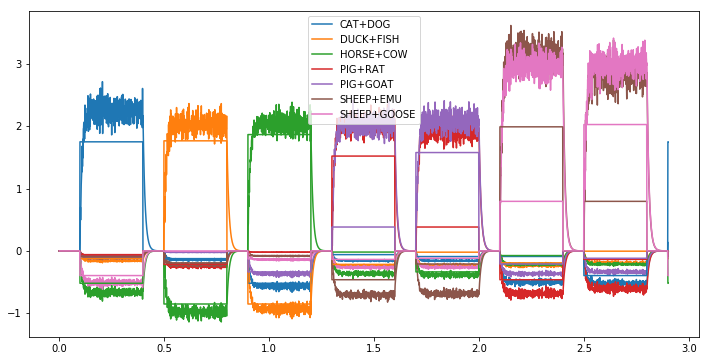

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], all_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], all_vecs))

plt.legend(all_labels)

In [11]:
def meg_from_spikes(spikes: np.ndarray, meg_syn=0.1):
    return nengo.Lowpass(meg_syn).filt(np.sum(spikes, axis=1))

In [12]:
ens_responses = [meg_from_spikes(sim.data[p_spk]) for p_spk in p_spikes]

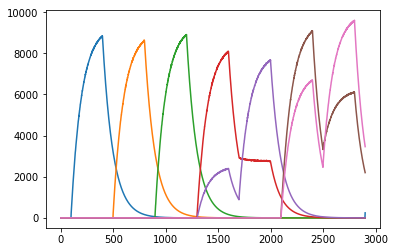

In [13]:
for ens_rep in ens_responses:
    plt.plot(ens_rep)

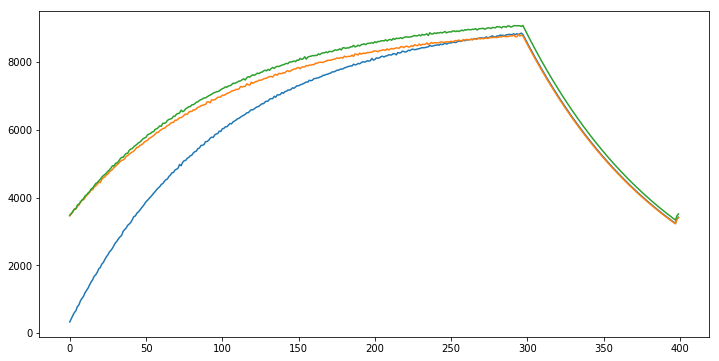

In [17]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)

fan1_resp = []

for t_p in range(t_paus, len(fan1)*slc_tm, slc_tm):
    fan1_resp.append(resp_sum[t_p:t_p+slc_tm])
    plt.plot(fan1_resp[-1])

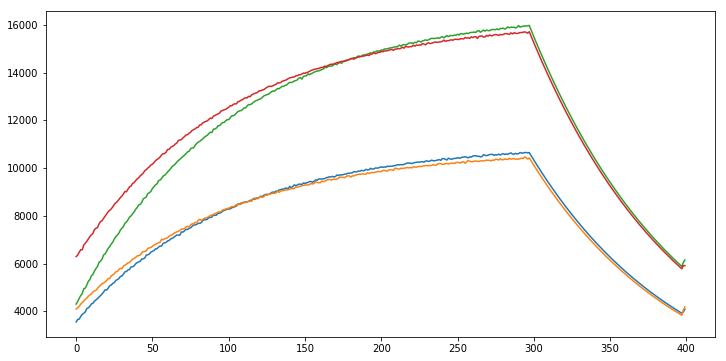

In [18]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)
fan2_resp = []

for t_p in range(t_paus+len(fan1)*slc_tm, (len(fan1)+len(fan2))*slc_tm, slc_tm):
    fan2_resp.append(resp_sum[t_p:t_p+slc_tm])
    plt.plot(fan2_resp[-1])

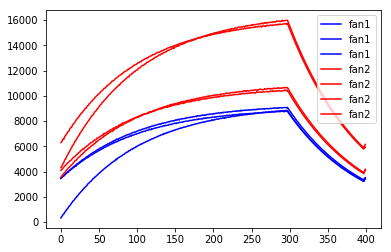

In [19]:
plt.plot(np.array(fan1_resp).T, color='blue', label="fan1")
plt.plot(np.array(fan2_resp).T, color='red', label="fan2")
plt.legend()

In [20]:
frog = vocab.parse("FROG").v
stim.output = lambda t: frog
correct.output = lambda t: frog

with nengo.Simulator(model) as sim:
    sim.run(t_present)

/home/saubin/git/nengo/nengo/spa/vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=12)
  len(self.pointers)))


Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


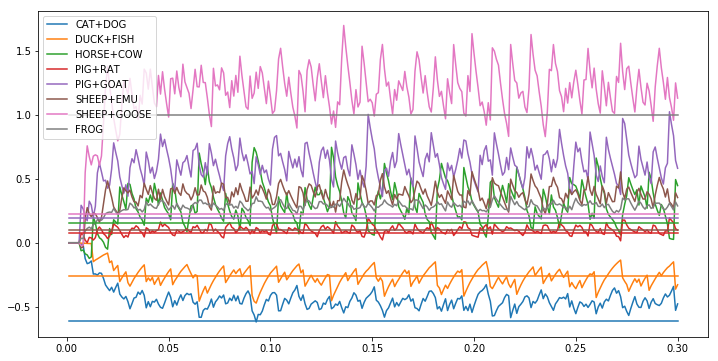

In [21]:
with_frog = np.concatenate((all_vecs, frog[None, :]), axis=0)

plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], with_frog))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], with_frog))

plt.legend(all_labels+["FROG"])

In [22]:
ens_responses = [
    meg_from_spikes(
        np.concatenate(
            (np.zeros((100, n_neurons)), sim.data[p_spk]), axis=0)
    ) for p_spk in p_spikes]

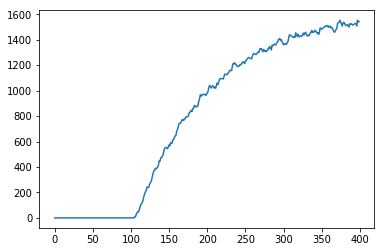

In [23]:
resp_sum = np.sum(ens_responses, axis=0)

plt.plot(resp_sum)

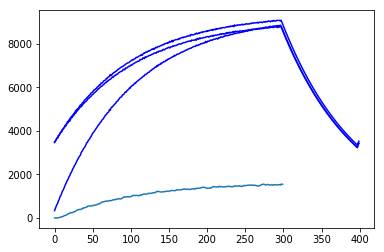

In [24]:
plt.plot(np.array(fan1_resp).T, color='blue', label="fan1")
plt.plot(resp_sum[100:])

# Basic voja memory

In [70]:
from nengo_learn_assoc_mem.learn_assoc import LearningAssocMem

n_neurons = 10
dimensions = 32
data_feed = BasicVecFeed(all_vecs, all_vecs, t_present, dimensions, len(all_vecs), t_pause)

def is_ans(t, x):
    if np.abs(np.sum(x)) > 0:
        return 1
    else:
        return -1

with nengo.Network() as model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)
    learn_control = nengo.Node(is_ans, size_in=dimensions)
    
    # Note: setting the intercept doesn't really change much, because there's so much similarity already
    mem = LearningAssocMem(n_neurons, dimensions, voja_rate=1e-4, pes_rate=1e-3, intercepts=np.ones(n_neurons)*0.1, seed=seed)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(correct, mem.correct, synapse=None)

    nengo.Connection(correct, learn_control, synapse=None)
    nengo.Connection(learn_control, mem.stop_learn)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = nengo.Probe(mem.mem.neurons, synapse=None)

    p_enc = nengo.Probe(mem.mem, 'scaled_encoders', sample_every=0.1)
    p_dec = nengo.Probe(mem.conn_out, 'weights', sample_every=0.1)

In [71]:
with nengo.Simulator(model) as sim:
    sim.run(len(all_labels)*(t_present+t_pause)*6 + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:05.                                                 


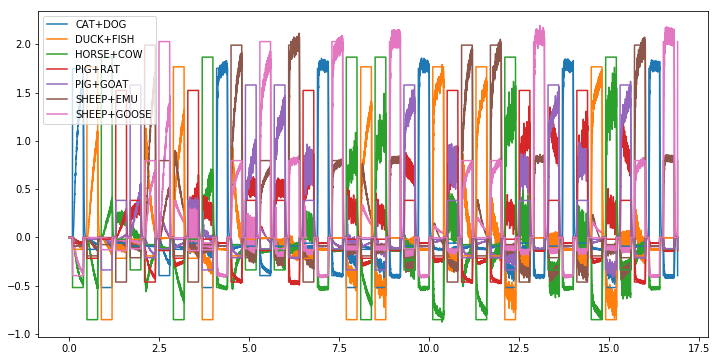

In [72]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], all_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], all_vecs))

plt.legend(all_labels)

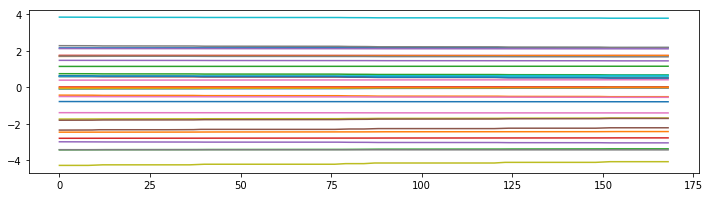

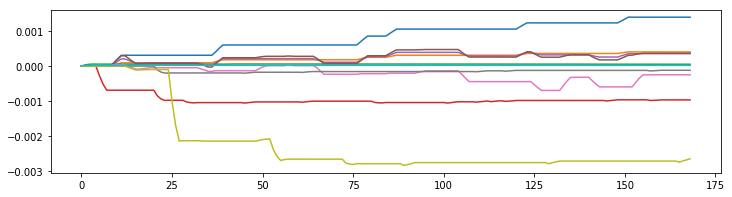

In [73]:
plt.figure(figsize=(12, 3))

plt.plot(sim.data[p_enc][:, 0, :]);

plt.figure(figsize=(12, 3))

plt.plot(sim.data[p_dec][:, 0, :]);

In [74]:
load_from = {}
load_from["enc"] = sim.data[p_enc][-1].copy()
load_from["dec"] = sim.data[p_dec][-1].copy()
load_from["seed"] = seed

with nengo.Network() as model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)

    mem = LearningAssocMem(n_neurons, dimensions, voja_rate=0, pes_rate=0, load_from=load_from, intercepts=np.ones(n_neurons)*0.1)
    
    nengo.Connection(stim, mem.input, synapse=None)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = nengo.Probe(mem.mem.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(all_labels)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


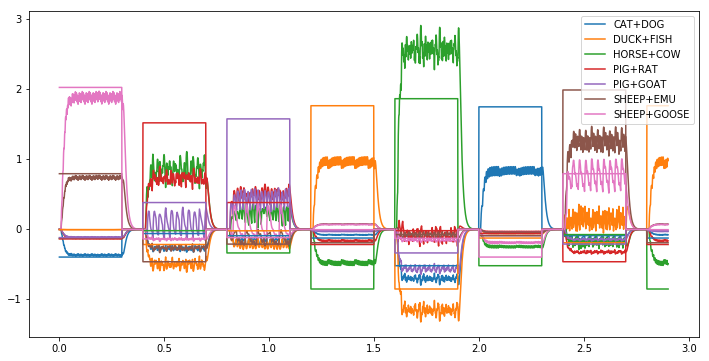

In [75]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], all_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], all_vecs))

plt.legend(all_labels)

In [57]:
ens_responses = meg_from_spikes(
    np.concatenate(
        (np.zeros((100, n_neurons)), sim.data[p_spikes]), axis=0)
)

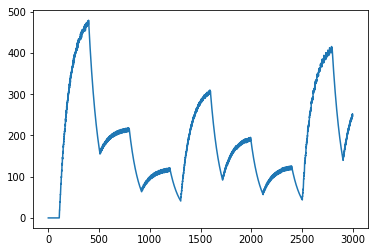

In [58]:
plt.plot(ens_responses)

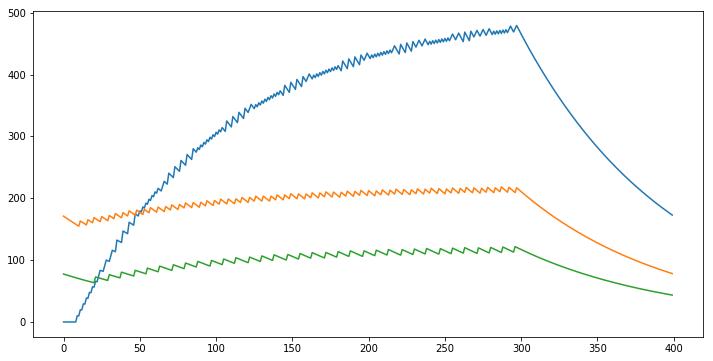

In [59]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)

fan1_resp = []

for t_p in range(t_paus, len(fan1)*slc_tm, slc_tm):
    fan1_resp.append(ens_responses[t_p:t_p+slc_tm])
    plt.plot(fan1_resp[-1])

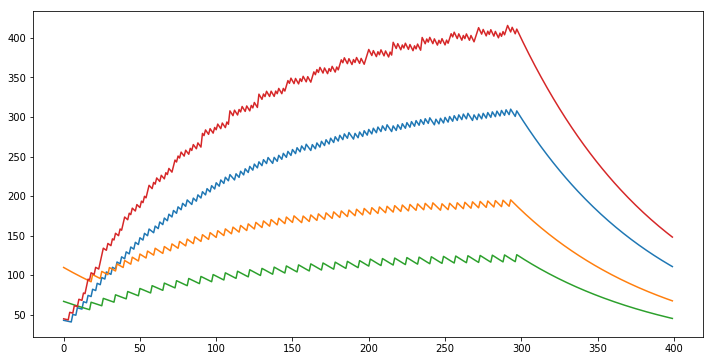

In [60]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)
fan2_resp = []

for t_p in range(t_paus+len(fan1)*slc_tm, (len(fan1)+len(fan2))*slc_tm, slc_tm):
    fan2_resp.append(ens_responses[t_p:t_p+slc_tm])
    plt.plot(fan2_resp[-1])

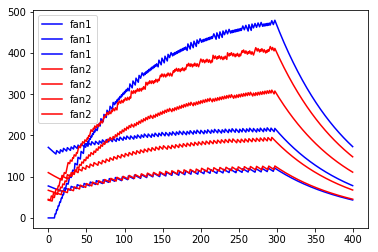

In [61]:
plt.plot(np.array(fan1_resp).T, color='blue', label="fan1")
plt.plot(np.array(fan2_resp).T, color='red', label="fan2")
plt.legend()

In [36]:
frog = vocab.parse("FROG").v
stim.output = lambda t: frog
correct.output = lambda t: frog

with nengo.Simulator(model) as sim:
    sim.run(t_present)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


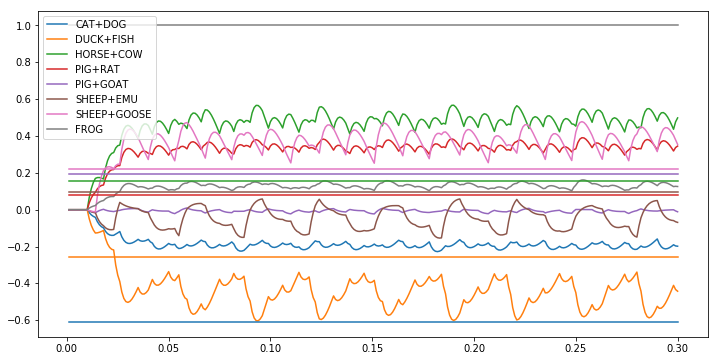

In [37]:
with_frog = np.concatenate((all_vecs, frog[None, :]), axis=0)

plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], with_frog))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], with_frog))

plt.legend(all_labels+["FROG"])

In [39]:
ens_responses = [
    meg_from_spikes(
        np.concatenate(
            (np.zeros((100, n_neurons)), sim.data[p_spikes]), axis=0)
    )]

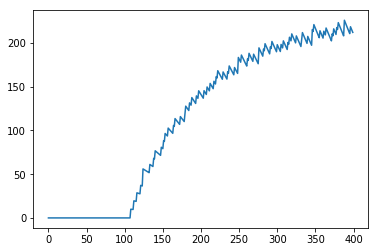

In [40]:
resp_sum = np.sum(ens_responses, axis=0)

plt.plot(resp_sum)

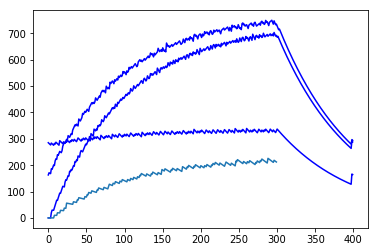

In [41]:
plt.plot(np.array(fan1_resp).T, color='blue', label="fan1")
plt.plot(resp_sum[100:])